In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
num_epochs = 30
batch_size = 128

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [0, 1] => [-1, 1]
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=4)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


(-0.5, 132.5, 132.5, -0.5)

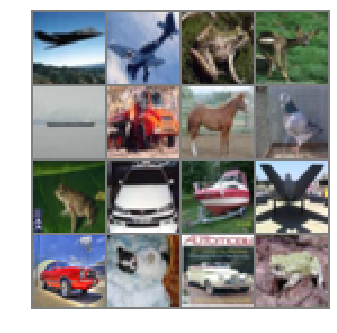

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # unnormalize [-1, 1] => [0, 1]
    img = img / 2 + 0.5
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = iter(train_loader).next()
images, labels = images[:16], labels[:16]
imshow(torchvision.utils.make_grid(images, nrow=4, padding=1))
plt.axis('off')

In [0]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN().to(device)

In [9]:
print(labels)

tensor([ 0,  0,  6,  4,  8,  9,  7,  2,  6,  1,  8,  0,  1,  5,
         1,  6])


In [10]:
print(model)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [11]:
images, labels = iter(train_loader).next()
outputs = model(images.to(device))
print(outputs.size())

torch.Size([128, 10])


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train(train_loader):
    model.train()
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss = running_loss / len(train_loader)

    return train_loss


def valid(test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = outputs.max(1, keepdim=True)[1]
            correct += predicted.eq(labels.view_as(predicted)).sum().item()

            total += labels.size(0)

    val_loss = running_loss / len(test_loader)
    val_acc = correct / total

    return val_loss, val_acc

In [13]:
loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)

    print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
          % (epoch, loss, val_loss, val_acc))

    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

print('Finished training')

epoch 0, loss: 1.7735 val_loss: 1.5283 val_acc: 0.4430
epoch 1, loss: 1.4556 val_loss: 1.3730 val_acc: 0.5058
epoch 2, loss: 1.3192 val_loss: 1.2910 val_acc: 0.5362
epoch 3, loss: 1.2280 val_loss: 1.2167 val_acc: 0.5639
epoch 4, loss: 1.1599 val_loss: 1.1786 val_acc: 0.5860
epoch 5, loss: 1.1013 val_loss: 1.1400 val_acc: 0.5991
epoch 6, loss: 1.0578 val_loss: 1.1020 val_acc: 0.6122
epoch 7, loss: 1.0138 val_loss: 1.0750 val_acc: 0.6237
epoch 8, loss: 0.9754 val_loss: 1.0587 val_acc: 0.6330
epoch 9, loss: 0.9372 val_loss: 1.0377 val_acc: 0.6389
epoch 10, loss: 0.9058 val_loss: 1.0325 val_acc: 0.6421
epoch 11, loss: 0.8802 val_loss: 1.0125 val_acc: 0.6469
epoch 12, loss: 0.8501 val_loss: 1.0203 val_acc: 0.6454
epoch 13, loss: 0.8234 val_loss: 1.0147 val_acc: 0.6486
epoch 14, loss: 0.7971 val_loss: 0.9938 val_acc: 0.6578
epoch 15, loss: 0.7733 val_loss: 1.0119 val_acc: 0.6556
epoch 16, loss: 0.7533 val_loss: 1.0347 val_acc: 0.6463
epoch 17, loss: 0.7298 val_loss: 1.0168 val_acc: 0.6599
ep

Text(0,0.5,'acc')

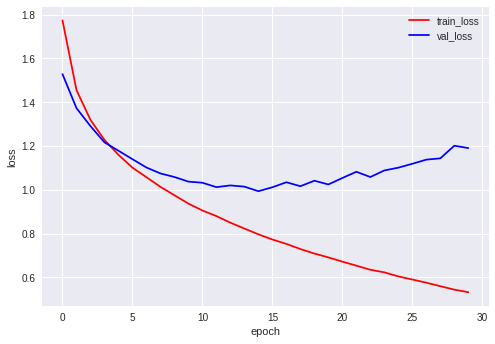

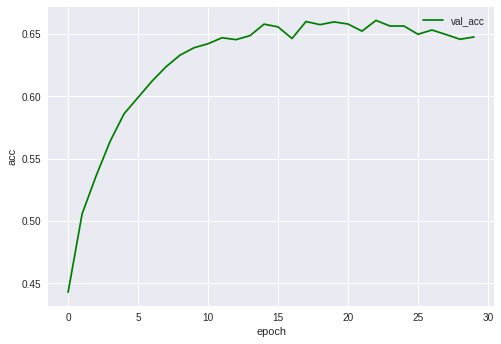

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# plot learning curve
plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.figure()
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')